# Anomalous sound detection : 1st try with a supervised classification technique

In [1]:
import librosa
import IPython.display as ipd
import librosa.display
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, classification_report
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectPercentile, f_classif
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

import xgboost as xgb

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
#%matplotlib notebook
%matplotlib inline

In [2]:
#Constant used throughout the notebook
PATH_TRAINING_DATASET = r"C:\Users\genef\Desktop\DATA_SCIENTEST\Projet\Dataset_DCASE2022Task2"
#PATH_ADDITIONNAL_DATASET = './Datasets/Additionnal/'

Function to create dataframes for all machine types containing the filename of each sample, its section, its attribute and type of sound.

In [3]:
def build_dataframe(machine_str = 'valve'):
    #Get list of files in train and test directory
    path_train_folder = PATH_TRAINING_DATASET + "\\dev_" + machine_str + "\\" + machine_str + "\\train"
    path_test_folder = PATH_TRAINING_DATASET  + "\\dev_" + machine_str + "\\" + machine_str + "\\test"

    train_files = [f for f in os.listdir(path_train_folder)]
    test_files = [f for f in os.listdir(path_test_folder)]

    #Get list of dictionnary for creating DataFrame
    list_dict_file = []

    #Loop through filenames
    for filename in train_files:

        #Get filename as list of string
        splitted_filename = filename.split('_')

        #Append dictionnary to list
        list_dict_file.append({
            'filepath' : path_train_folder + "\\" + filename,
            'filename' : filename,
            'machine' : machine_str,
            'section' : int(splitted_filename[1]),
            'domain_env' : splitted_filename[2],
            'dir' : splitted_filename[3],
            'sound_type' : splitted_filename[4],
            'id' : splitted_filename[5],
            'suffix' : '_'.join(splitted_filename[6:]).split('.wav')[0]  
        })

    #Loop through filenames
    for filename in test_files:

        #Get filename as list of string
        splitted_filename = filename.split('_')

        #Append dictionnary to list
        list_dict_file.append({
            'filepath' : path_test_folder  + "\\" + filename,
            'filename' : filename,
            'machine' : machine_str,
            'section' : int(splitted_filename[1]),
            'domain_env' : splitted_filename[2],
            'dir' : splitted_filename[3],
            'sound_type' : splitted_filename[4],
            'id' : splitted_filename[5],
            'suffix' : '_'.join(splitted_filename[6:]).split('.wav')[0] 
        })
        
    return pd.DataFrame(list_dict_file)


def sound_from_file(filename, machine_str = 'valve', dataset = 'train'):
    df = build_dataframe(machine_str)
    path = PATH_TRAINING_DATASET + "\\dev_" + machine_str + "\\" + machine_str + "\\" + dataset + "\\" + filename
    return df[df['filepath']==path].iloc[0]
    


df_fan = build_dataframe('fan')
df_valve = build_dataframe('valve')
df_bearing = build_dataframe('bearing')
df_slider = build_dataframe('slider')
df_car = build_dataframe('ToyCar')
df_train = build_dataframe('ToyTrain')
df_gearbox = build_dataframe('gearbox')

df_fan.info()
df_gearbox.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600 entries, 0 to 3599
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   filepath    3600 non-null   object
 1   filename    3600 non-null   object
 2   machine     3600 non-null   object
 3   section     3600 non-null   int64 
 4   domain_env  3600 non-null   object
 5   dir         3600 non-null   object
 6   sound_type  3600 non-null   object
 7   id          3600 non-null   object
 8   suffix      3600 non-null   object
dtypes: int64(1), object(8)
memory usage: 253.2+ KB


,filepath,filename,machine,section,domain_env,dir,sound_type,id,suffix
0,C:\Users\genef\Desktop\DATA_SCIENTEST\Projet\D...,section_00_source_train_normal_0000_volt_1.0.wav,gearbox,0,source,train,normal,0000,volt_1.0
1,C:\Users\genef\Desktop\DATA_SCIENTEST\Projet\D...,section_00_source_train_normal_0001_volt_2.5.wav,gearbox,0,source,train,normal,0001,volt_2.5
2,C:\Users\genef\Desktop\DATA_SCIENTEST\Projet\D...,section_00_source_train_normal_0002_volt_1.5.wav,gearbox,0,source,train,normal,0002,volt_1.5
3,C:\Users\genef\Desktop\DATA_SCIENTEST\Projet\D...,section_00_source_train_normal_0003_volt_2.0.wav,gearbox,0,source,train,normal,0003,volt_2.0
4,C:\Users\genef\Desktop\DATA_SCIENTEST\Projet\D...,section_00_source_train_normal_0004_volt_1.0.wav,gearbox,0,source,train,normal,0004,volt_1.0


Function to get the data matrix of amplitude spectrograms and the data matrix of phase spectrograms from a dataframe 

In [4]:
def load_audio(file_path):
    y, sr = librosa.load(file_path, sr = None)
    return y, sr

def spectrogram(audio, n_fft = 1024, hop_length = 512):
    spectrum = librosa.stft(audio, n_fft = n_fft, hop_length = hop_length, center = False)
    # Chose center = False above after doing a test on a simple superposition of two sin with two frequencies
    # There are boundary artifacts in the spectrograms if center = True
    # Not investigated why it is like this but the spectrograms look definitely better with center = False
    # To be confirmed
    magnitude, phase = librosa.magphase(spectrum)
    magnitude_in_db = librosa.amplitude_to_db(magnitude, ref=1e-6)
    # or ref=np.max. ref = 1e-6 corresponds to the threshold intensity for humans = 1e-12 W/m2
    # Not sure of the units. Does not matter, I just want a fixed ref for all spectrograms
    return magnitude_in_db, np.angle(phase)    

def get_spectros_from_df(df, n_fft = 1024, hop_length = 512):
    def path_to_spectra(path):
        y, sr = load_audio(path)
        mag_sp, phase_sp = spectrogram(y, n_fft = n_fft, hop_length = hop_length)
        return mag_sp.flatten(), phase_sp.flatten()     
    
    filepaths = df['filepath'].reset_index(drop = True)
    X_tmp = path_to_spectra(filepaths.iloc[0])[0]     # to get the size of a flatten spectrum
    X_mag = np.empty((filepaths.shape[0], X_tmp.size))
    X_phase = np.empty((filepaths.shape[0], X_tmp.size))
                   
    for i, path in filepaths.items():
        mag_sp, phase_sp = path_to_spectra(path)
        X_mag[i] = mag_sp
        X_phase[i] = phase_sp

    return X_mag, X_phase

# Same for amplitude mel spectrograms
def get_2D_mel_spectros_from_df(df, n_fft = 1024, hop_length = 512, n_mels = 32):
    def get_mel_spectrum_from_path(path):
        y, sr = load_audio(path)
        M = librosa.feature.melspectrogram(y, sr = sr, n_fft = n_fft, hop_length = hop_length, n_mels = n_mels, \
                                           center = False)
        M_db = librosa.power_to_db(M, ref=1e-12)   # or ref=np.max
        return M_db   

    filepaths = df['filepath'].reset_index(drop = True)
            
    for s, path in filepaths.items():
        mag_sp = get_mel_spectrum_from_path(path)
  
        X_tmp = get_mel_spectrum_from_path(filepaths.iloc[0])     # to get the size of a spectrum
        X_mag = np.empty((filepaths.shape[0], *X_tmp.shape))
        X_mag[s] = mag_sp

    return X_mag
                                                                                
    
#X_mag, X_phase = get_spectros_from_df(df_gearbox[(df_gearbox['dir']=='test') & (df_gearbox['section']==0)])



## Choose data

In [5]:
# Fix the parameters
params = dict(n_fft = 1024,        # n_fft paramater for calculating the spectrograms with librosa.stft
              hop_length = 512     # hop_length paramater for calculating the spectrograms with librosa.stft
             )

In [6]:
machine_list = ['bearing', 'fan', 'gearbox', 'slider', 'ToyCar', 'ToyTrain', 'valve']
df = pd.concat([build_dataframe(machine) for machine in machine_list], axis = 0).reset_index()

#Encoding labels
label_encoder = LabelEncoder()
df['machine_num'] = label_encoder.fit_transform(df['machine'])
display(df.head())

dico = {}
for i in range(7):
    dico[label_encoder.inverse_transform([i])[0]] = i
pd.DataFrame.from_dict(dico, orient = 'index', columns = ['machine_num'])




,index,filepath,filename,machine,section,domain_env,dir,sound_type,id,suffix,machine_num
0,0,C:\Users\genef\Desktop\DATA_SCIENTEST\Projet\D...,section_00_source_train_normal_0000_vel_22.wav,bearing,0,source,train,normal,0000,vel_22,2
1,1,C:\Users\genef\Desktop\DATA_SCIENTEST\Projet\D...,section_00_source_train_normal_0001_vel_22.wav,bearing,0,source,train,normal,0001,vel_22,2
2,2,C:\Users\genef\Desktop\DATA_SCIENTEST\Projet\D...,section_00_source_train_normal_0002_vel_18.wav,bearing,0,source,train,normal,0002,vel_18,2
3,3,C:\Users\genef\Desktop\DATA_SCIENTEST\Projet\D...,section_00_source_train_normal_0003_vel_14.wav,bearing,0,source,train,normal,0003,vel_14,2
4,4,C:\Users\genef\Desktop\DATA_SCIENTEST\Projet\D...,section_00_source_train_normal_0004_vel_6.wav,bearing,0,source,train,normal,0004,vel_6,2


,machine_num
ToyCar,0
ToyTrain,1
bearing,2
fan,3
gearbox,4
slider,5
valve,6


In [7]:
train_data = df[df['dir']=='train'].groupby('machine').sample(n = 200, random_state = 1)
test_data = df[df['dir']=='test'].groupby('machine').sample(n = 200, random_state = 1)

X_mag, X_phase = get_spectros_from_df(train_data, n_fft = params['n_fft'], hop_length = params['hop_length'])
target = train_data['machine_num']

X_mag_test, X_phase_test = get_spectros_from_df(test_data, n_fft = params['n_fft'], hop_length = params['hop_length'])
y_test = test_data['machine_num']

In [8]:
target.value_counts()

0    200
1    200
2    200
3    200
4    200
5    200
6    200
Name: machine_num, dtype: int64

## Split in training and test sets

In [9]:
# Choose here if the training is done on the amplitude spectrogram, phase spectrogram or both
which = 'amplitude'      # 'amplitude', 'phase', or 'both'

In [10]:
def my_train_test_split(X_mag, X_phase, target, which = 'amplitude', test_size = 0.2, random_state = 123):
    if which == 'amplitude':
        X = X_mag
    elif which == 'phase':
        X = X_phase
    elif which == 'both':
        X = np.concatenate([X_mag, X_phase], axis = 1)
    else:
        raise ValueError("'which' must be equal to 'amplitude', 'phase' or 'both'")
        
    X_train, X_test, y_train, y_test = train_test_split(X, target, test_size = test_size, random_state = random_state)
    
    return X_train, X_test, y_train, y_test


In [11]:
X_train, X_eval, y_train, y_eval = my_train_test_split(X_mag, X_phase, target, which = which)

# Define X_test
if which == 'amplitude':
    X_test = X_mag_test
elif which == 'phase':
    X_test = X_phase_test
elif which == 'both':
    X_test = np.concatenate([X_mag_test, X_phase_test], axis = 1)

## Dimensionality reduction

#### First feature selection, then PCA

In [12]:
sel = SelectPercentile(score_func = f_classif, percentile = 30)
sel.fit(X_train, y_train)
X_red_train = sel.transform(X_train)
X_red_eval = sel.transform(X_eval)
X_red_test = sel.transform(X_test)

In [13]:
n_feats = X_red_train.shape[1]
pca = PCA(n_components = 0.85)       # keep 85% of variance
pca.fit(X_red_train)
X_red_train = pca.transform(X_red_train)
X_red_eval = pca.transform(X_red_eval)
X_red_test = pca.transform(X_red_test)

print("Number of initial features = ", n_feats)
print("Number of selected features = ", pca.n_components_)

Number of initial features =  47863
Number of selected features =  332


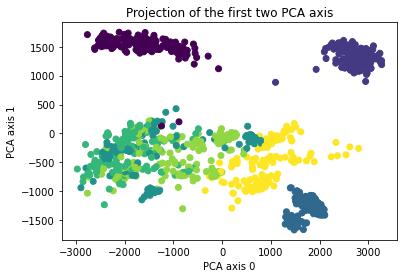

In [14]:
plt.scatter(X_red_train[:,0], X_red_train[:,1], c = y_train)
plt.xlabel("PCA axis 0")
plt.ylabel("PCA axis 1")
plt.title("Projection of the first two PCA axis");

## Machine learning

#### First classification method : Gradient Boosting

In [15]:
# Convert arrays to DMatrices
M_red_train = xgb.DMatrix(X_red_train, y_train)
M_red_eval = xgb.DMatrix(X_red_eval, y_eval)

In [16]:
# Training
params_xgb = {'booster': 'gbtree',
              'learning_rate': 1,
              'alpha': 0.001,     # L1 regularization term
              'eval_metric': 'merror',
              'objective': 'multi:softprob',
              'num_class': 7}

xgb_model = xgb.train(dtrain = M_red_train, params = params_xgb, num_boost_round = 1000, \
                      early_stopping_rounds = 20, evals = [(M_red_train, 'train'), (M_red_eval, 'eval')])

train_pred_probas = xgb_model.predict(M_red_train, iteration_range = (0, xgb_model.best_iteration + 1))
train_preds = np.argmax(train_pred_probas, axis=1)

eval_pred_probas = xgb_model.predict(M_red_eval, iteration_range = (0, xgb_model.best_iteration + 1))
eval_preds = np.argmax(eval_pred_probas, axis=1)



[0]	train-merror:0.02946	eval-merror:0.12857
[1]	train-merror:0.00357	eval-merror:0.06786
[2]	train-merror:0.00000	eval-merror:0.05714
[3]	train-merror:0.00000	eval-merror:0.05357
[4]	train-merror:0.00000	eval-merror:0.05000
[5]	train-merror:0.00000	eval-merror:0.03929
[6]	train-merror:0.00000	eval-merror:0.03214
[7]	train-merror:0.00000	eval-merror:0.03214
[8]	train-merror:0.00000	eval-merror:0.03571
[9]	train-merror:0.00000	eval-merror:0.03571
[10]	train-merror:0.00000	eval-merror:0.02857
[11]	train-merror:0.00000	eval-merror:0.02857
[12]	train-merror:0.00000	eval-merror:0.02143
[13]	train-merror:0.00000	eval-merror:0.02857
[14]	train-merror:0.00000	eval-merror:0.02500
[15]	train-merror:0.00000	eval-merror:0.02143
[16]	train-merror:0.00000	eval-merror:0.02500
[17]	train-merror:0.00000	eval-merror:0.02143
[18]	train-merror:0.00000	eval-merror:0.02500
[19]	train-merror:0.00000	eval-merror:0.02143
[20]	train-merror:0.00000	eval-merror:0.02143
[21]	train-merror:0.00000	eval-merror:0.0214

Clearly the model is overfitting.

Let's try to adjust the parameters learning_rate and alpha

In [17]:
learning_rates = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
alphas = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]

accuracies = []    # list to store auc
for alpha in alphas:
    for learning_rate in learning_rates:
        params_xgb = {'booster': 'gbtree',
                      'learning_rate': learning_rate,
                      'alpha': alpha,     # L1 regularization term
                      'eval_metric': 'merror',
                      'objective': 'multi:softprob',
                      'num_class': 7}

        xgb_model = xgb.train(dtrain = M_red_train, params = params_xgb, num_boost_round = 1000, \
                      early_stopping_rounds = 20, evals = [(M_red_train, 'train'), (M_red_eval, 'eval')], \
                      verbose_eval = False)

        pred_probas = xgb_model.predict(M_red_eval, iteration_range = (0, xgb_model.best_iteration + 1))
        preds = np.argmax(pred_probas, axis=1)
        accuracy = accuracy_score(y_eval, preds)
        accuracies.append([alpha, learning_rate, accuracy])
 

        
        

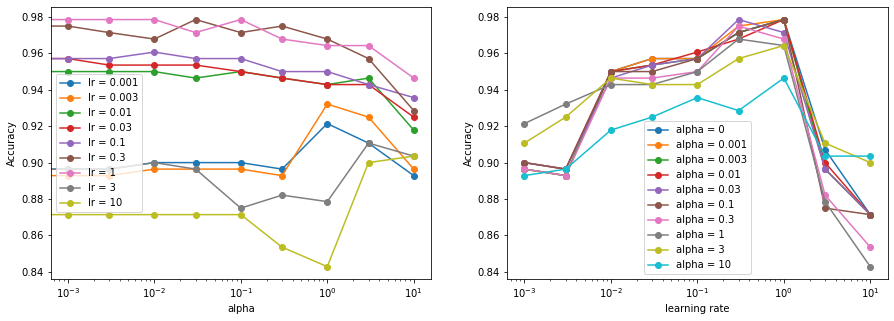

In [18]:
acc = np.array(accuracies)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
for lr in learning_rates:
    acc_lr = acc[acc[:,1]==lr]
    ax1.plot(acc_lr[:,0], acc_lr[:,2], "-o", label = "lr = " + str(lr))
    ax1.set_xlabel("alpha")
    ax1.set_ylabel("Accuracy")
    ax1.set_xscale('log')
    ax1.legend(loc = 'best')
    
for alpha in alphas:
    acc_alpha = acc[acc[:,0]==alpha]
    ax2.plot(acc_alpha[:,1], acc_alpha[:,2], "-o", label = "alpha = " + str(alpha))
    ax2.set_xlabel("learning rate")
    ax2.set_ylabel("Accuracy")
    ax2.set_xscale('log')
    ax2.legend(loc = 'best')

## Predict on the test set

In [19]:
M_red_test = xgb.DMatrix(X_red_test, y_test)

test_pred_probas = xgb_model.predict(M_red_test, iteration_range = (0, xgb_model.best_iteration + 1))
test_preds = np.argmax(test_pred_probas, axis=1)

## Performance evaluation

In [20]:
def show_evaluations(pred_machine_proba, test_df):
    y_pred_machine = np.argmax(pred_machine_proba, axis=1)
    y_true_machine = test_df['machine_num'][:len(y_pred_machine)]   

    print("***** EVALUATION OF MACHINE CLASSIFICATION ***** ")
    print(classification_report(y_true_machine, y_pred_machine))
    display(pd.crosstab(y_true_machine, y_pred_machine, rownames = ['True'], colnames = ['Pred']))
    print('\n')



In [21]:
show_evaluations(test_pred_probas, test_data)

***** EVALUATION OF MACHINE CLASSIFICATION ***** 
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       200
           1       1.00      0.80      0.89       200
           2       0.98      0.84      0.91       200
           3       0.76      0.51      0.61       200
           4       0.61      0.91      0.73       200
           5       0.75      0.73      0.74       200
           6       0.79      0.86      0.82       200

    accuracy                           0.80      1400
   macro avg       0.82      0.80      0.80      1400
weighted avg       0.82      0.80      0.80      1400



Pred,0,1,2,3,4,5,6
True,,,,,,,
0,193,0,0,2,4,1,0
1,1,160,0,0,26,0,13
2,8,0,169,7,11,0,5
3,2,0,2,102,39,31,24
4,0,0,0,7,181,12,0
5,3,0,1,17,28,146,5
6,15,0,1,0,8,4,172


## Repeat by considering only sounds from the source domain

In [22]:
train_data = df[(df['dir']=='train') & (df['domain_env']=='source')].groupby('machine').sample(n = 200, random_state = 1)
test_data = df[(df['dir']=='test') & (df['domain_env']=='source')].groupby('machine').sample(n = 200, random_state = 1)

X_mag, X_phase = get_spectros_from_df(train_data, n_fft = params['n_fft'], hop_length = params['hop_length'])
target = train_data['machine_num']

X_mag_test, X_phase_test = get_spectros_from_df(test_data, n_fft = params['n_fft'], hop_length = params['hop_length'])
y_test = test_data['machine_num']

In [23]:
# Choose here if the training is done on the amplitude spectrogram, phase spectrogram or both
which = 'amplitude'      # 'amplitude', 'phase', or 'both'

X_train, X_eval, y_train, y_eval = my_train_test_split(X_mag, X_phase, target, which = which)

# Define X_test
if which == 'amplitude':
    X_test = X_mag_test
elif which == 'phase':
    X_test = X_phase_test
elif which == 'both':
    X_test = np.concatenate([X_mag_test, X_phase_test], axis = 1)

#### Dimensionality reduction

In [24]:
sel = SelectPercentile(score_func = f_classif, percentile = 30)
sel.fit(X_train, y_train)
X_red_train = sel.transform(X_train)
X_red_eval = sel.transform(X_eval)
X_red_test = sel.transform(X_test)

In [25]:
n_feats = X_red_train.shape[1]
pca = PCA(n_components = 0.85)       # keep 85% of variance
pca.fit(X_red_train)
X_red_train = pca.transform(X_red_train)
X_red_eval = pca.transform(X_red_eval)
X_red_test = pca.transform(X_red_test)

print("Number of initial features = ", n_feats)
print("Number of selected features = ", pca.n_components_)

Number of initial features =  47863
Number of selected features =  318


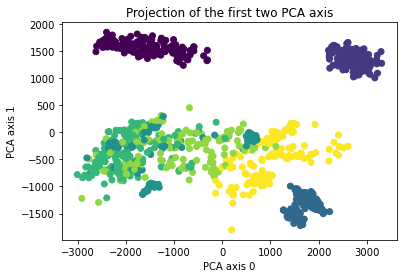

In [26]:
plt.scatter(X_red_train[:,0], X_red_train[:,1], c = y_train)
plt.xlabel("PCA axis 0")
plt.ylabel("PCA axis 1")
plt.title("Projection of the first two PCA axis");

#### Machine learning

In [27]:
# Convert arrays to DMatrices
M_red_train = xgb.DMatrix(X_red_train, y_train)
M_red_eval = xgb.DMatrix(X_red_eval, y_eval)

In [28]:
learning_rates = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
alphas = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]

accuracies = []    # list to store auc
for alpha in alphas:
    for learning_rate in learning_rates:
        params_xgb = {'booster': 'gbtree',
                      'learning_rate': learning_rate,
                      'alpha': alpha,     # L1 regularization term
                      'eval_metric': 'merror',
                      'objective': 'multi:softprob',
                      'num_class': 7}

        xgb_model = xgb.train(dtrain = M_red_train, params = params_xgb, num_boost_round = 1000, \
                      early_stopping_rounds = 20, evals = [(M_red_train, 'train'), (M_red_eval, 'eval')], \
                      verbose_eval = False)

        pred_probas = xgb_model.predict(M_red_eval, iteration_range = (0, xgb_model.best_iteration + 1))
        preds = np.argmax(pred_probas, axis=1)
        accuracy = accuracy_score(y_eval, preds)
        accuracies.append([alpha, learning_rate, accuracy])
 

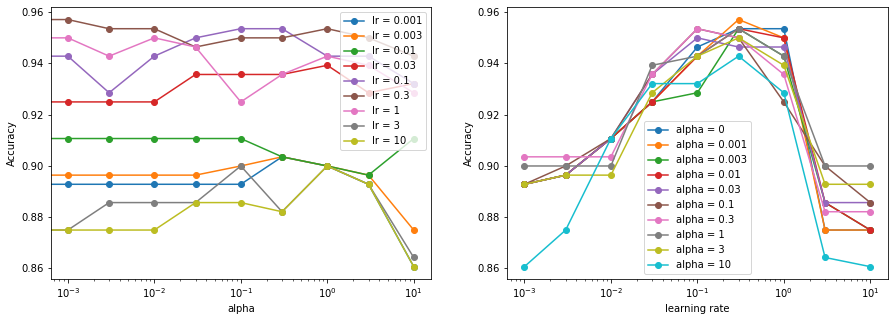

In [29]:
acc = np.array(accuracies)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
for lr in learning_rates:
    acc_lr = acc[acc[:,1]==lr]
    ax1.plot(acc_lr[:,0], acc_lr[:,2], "-o", label = "lr = " + str(lr))
    ax1.set_xlabel("alpha")
    ax1.set_ylabel("Accuracy")
    ax1.set_xscale('log')
    ax1.legend(loc = 'best')
    
for alpha in alphas:
    acc_alpha = acc[acc[:,0]==alpha]
    ax2.plot(acc_alpha[:,1], acc_alpha[:,2], "-o", label = "alpha = " + str(alpha))
    ax2.set_xlabel("learning rate")
    ax2.set_ylabel("Accuracy")
    ax2.set_xscale('log')
    ax2.legend(loc = 'best')

In [30]:
# Training
params_xgb = {'booster': 'gbtree',
              'learning_rate': 0.3,
              'alpha': 0.001,     # L1 regularization term
              'eval_metric': 'merror',
              'objective': 'multi:softprob',
              'num_class': 7}

xgb_model = xgb.train(dtrain = M_red_train, params = params_xgb, num_boost_round = 1000, \
                      early_stopping_rounds = 20, evals = [(M_red_train, 'train'), (M_red_eval, 'eval')])

train_pred_probas = xgb_model.predict(M_red_train, iteration_range = (0, xgb_model.best_iteration + 1))
train_preds = np.argmax(train_pred_probas, axis=1)

eval_pred_probas = xgb_model.predict(M_red_eval, iteration_range = (0, xgb_model.best_iteration + 1))
eval_preds = np.argmax(eval_pred_probas, axis=1)


[0]	train-merror:0.02143	eval-merror:0.12500
[1]	train-merror:0.00536	eval-merror:0.08929
[2]	train-merror:0.00446	eval-merror:0.07857
[3]	train-merror:0.00089	eval-merror:0.07500
[4]	train-merror:0.00000	eval-merror:0.06786
[5]	train-merror:0.00000	eval-merror:0.06786
[6]	train-merror:0.00000	eval-merror:0.06429
[7]	train-merror:0.00000	eval-merror:0.06429
[8]	train-merror:0.00000	eval-merror:0.06786
[9]	train-merror:0.00000	eval-merror:0.06786
[10]	train-merror:0.00000	eval-merror:0.06786
[11]	train-merror:0.00000	eval-merror:0.06786
[12]	train-merror:0.00000	eval-merror:0.06429
[13]	train-merror:0.00000	eval-merror:0.06071
[14]	train-merror:0.00000	eval-merror:0.06071
[15]	train-merror:0.00000	eval-merror:0.05714
[16]	train-merror:0.00000	eval-merror:0.05357
[17]	train-merror:0.00000	eval-merror:0.05000
[18]	train-merror:0.00000	eval-merror:0.04643
[19]	train-merror:0.00000	eval-merror:0.04643
[20]	train-merror:0.00000	eval-merror:0.04643
[21]	train-merror:0.00000	eval-merror:0.0428

### Predict

In [31]:
M_red_test = xgb.DMatrix(X_red_test, y_test)

test_pred_probas = xgb_model.predict(M_red_test, iteration_range = (0, xgb_model.best_iteration + 1))
test_preds = np.argmax(test_pred_probas, axis=1)

### Evaluate

In [32]:
show_evaluations(test_pred_probas, test_data)

***** EVALUATION OF MACHINE CLASSIFICATION ***** 
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       200
           1       1.00      1.00      1.00       200
           2       0.99      0.96      0.98       200
           3       0.87      0.86      0.86       200
           4       0.88      0.94      0.91       200
           5       0.92      0.81      0.86       200
           6       0.89      0.97      0.93       200

    accuracy                           0.93      1400
   macro avg       0.94      0.93      0.93      1400
weighted avg       0.94      0.93      0.93      1400



Pred,0,1,2,3,4,5,6
True,,,,,,,
0,198,0,0,0,0,2,0
1,0,200,0,0,0,0,0
2,0,0,193,0,0,0,7
3,0,0,0,172,12,8,8
4,0,0,0,7,189,4,0
5,0,0,0,18,11,162,9
6,0,0,2,1,3,0,194
